### Population Growth

In [2]:
# Import libraries / preliminaries
%config Completer.use_jedi = False
import pandas as pd
import matplotlib.pyplot as plt
import itertools
plt.rc('axes', edgecolor='white')
plt.rc('ytick',labelsize=8)
plt.rc('xtick',labelsize=8)

In [4]:
#Pre-1991 data from Births and Deaths and population 
# https://www.census.gov/library/publications/2006/
# compendia/statab/126ed/vital-statistics.html
# and 
# https://www2.census.gov/programs-surveys/popest/
# tables/1900-1980/national/totals/popclockest.txt
years = [1988, 1989, 1990, 1991]
births88 = [3809000, 3910000, 4041000, 4158000]
deaths88 = [2123000, 2168000, 2150000, 2148000]
total88 = [2210064, 2320248, 2645166, 2688696]
df88 = pd.DataFrame()
df88['BIRTHS'] = pd.Series(data=births88, index=years)
df88['DEATHS'] = pd.Series(data=deaths88, index=years)
df88['TOTAL'] = pd.Series(data=total88, index=years)
df88['NATURALINC'] = df88['BIRTHS'] - df88['DEATHS']
df88['NETMIG'] = df88['TOTAL'] - df88['NATURALINC']

# Copied these manually from here: https://www2.census.gov/programs-surveys/
# popest/tables/1990-2000/estimates-and-change-1990-2000/2000c8_00.txt
years = [2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991]
births90 = ['3,966,059',  '3,949,171',  '3,909,345',  '3,892,431',  
            '3,881,967',  '3,926,652',  '3,971,136',  '4,027,125',  
            '4,105,689',  '4,133,265']
deaths90 = ['2,386,995',  '2,359,088',  '2,330,759',  '2,321,933',  
            '2,317,918',  '2,284,363',  '2,282,854',  '2,226,027',  
            '2,180,115',  '2,138,906']
netmig90 = ['878,119', '862,845', '884,272', '930,821', '862,794', 
            '783,884', '763,264', '826,566', '792,335', '698,732']
df90 = pd.DataFrame()
df90['BIRTHS'] = (pd.Series(data=births90, index=years)
                    .str.replace(',', '').astype('int'))
df90['DEATHS'] = (pd.Series(data=deaths90, index=years)
                    .str.replace(',', '').astype('int'))
df90['NETMIG'] = (pd.Series(data=netmig90, index=years)
                    .str.replace(',', '').astype('int'))
df90['NATURALINC'] = df90['BIRTHS'] - df90['DEATHS']

In [5]:
# 2001 to 2010 data csv
url = ('https://www2.census.gov/programs-surveys/popest/datasets/'+
       '2010/2010-eval-estimates/co-est2010-alldata.csv')
df00 = pd.read_csv(url, encoding='iso-8859-1')

# 2011 to 2020 data csv
url = ('https://www2.census.gov/programs-surveys/popest/'+
       'datasets/2010-2020/state/totals/nst-est2020-alldata.csv')
df10 = pd.read_csv(url)

# 2023 file
file = ('https://www2.census.gov/programs-surveys/popest/tables/'+
        '2020-2023/state/totals/NST-EST2023-COMP.xlsx')
df = pd.read_excel(file, index_col=0, usecols='A:F', header=[3])
cols = ['Total', 'NATURALINC', 'BIRTHS', 'DEATHS', 'NETMIG']
df.columns = cols
df23 = df.loc['United States', cols[1:]]
# 2022 file
file = ('https://www2.census.gov/programs-surveys/popest/tables/'+
        '2020-2022/state/totals/NST-EST2022-COMP.xlsx')
df = pd.read_excel(file, index_col=0, usecols='A:F', header=[3])
cols = ['Total', 'NATURALINC', 'BIRTHS', 'DEATHS', 'NETMIG']
df.columns = cols
df22 = df.loc['United States', cols[1:]]
file = ('https://www2.census.gov/programs-surveys/popest/tables/'+
        '2020-2021/state/totals/NST-EST2021-COMP.xlsx')
df = pd.read_excel(file, index_col=0, usecols='A:F', header=[3])
cols = ['Total', 'NATURALINC', 'BIRTHS', 'DEATHS', 'NETMIG']
df.columns = cols
df21 = df.loc['United States', cols[1:]]

cats = ['BIRTHS', 'DEATHS', 'NATURALINC', 'NETMIG']
res = pd.DataFrame()
for cat, year in itertools.product(cats, range(2001, 2011)):
    data = df00.query('COUNTY == 0').sum().loc[f'{cat}{year}']
    res.at[year, cat] = data
for cat, year in itertools.product(cats, range(2011, 2021)):
    data = df10.query('NAME == "United States"').loc[0, f'{cat}{year}']
    res.at[year, cat] = data
res = pd.concat([df88, df90, res, df21.rename(2021).to_frame().T, 
                 df22.rename(2022).to_frame().T, 
                 df23.rename(2023).to_frame().T]).sort_index()
res.index = pd.to_datetime([f'{y}-07-01' for y in res.index])
res['TOTAL'] = res['NATURALINC'] + res['NETMIG']
res = res.sort_index() / 1_000_000
res.to_csv('popcomp_raw.csv', index_label='date')

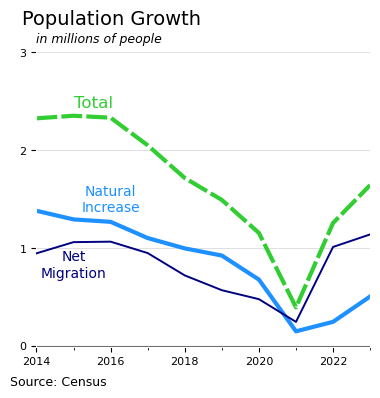

In [78]:
# Retrieve locally saved data and plot
res = pd.read_csv('popcomp_raw.csv', index_col='date', parse_dates=True)
res = res.loc['2014':]
res.index.name = ''

# Create chart
fig, ax = plt.subplots(figsize=(4.0, 3.5))
fig.tight_layout()
cols = ['NETMIG', 'NATURALINC', 'TOTAL']
colors = ['navy', 'dodgerblue', 'limegreen']
styles = ['-', '-', (0, (5,1))]
widths = [1.4, 3.0, 3.0]
zorder = [4, 1, 2]
for col, color, ls, lw, z in zip(cols, colors, styles, widths, zorder):
    res[col].plot(color=color, linestyle=ls, lw=lw, ax=ax, zorder=z)

yticks = [0,1,2,3]
ax.set_ylim(-0.01, 3.02)
ax.axhline(0, color='dimgray', lw=0.8)
ax.set_yticks(yticks)  
for xv in yticks:
    ax.axhline(xv, color='lightgray', lw=0.5, zorder=0)
       
# Annotations
ax.text('2015-01-01', 2.44, 'Total', color=colors[-1], size=12)
ax.text('2015-01-01', 0.98, 'Net\nMigration', color=colors[0], 
        size=10, ha='center', va='top')
ax.text('2016-01-01', 1.65, 'Natural\nIncrease', color=colors[1], 
        size=10, ha='center', va='top')
# Titles and footers
fig.text(0.07, 1.02, 'Population Growth', size=14)
subtitle = ('in millions of people')
ax.set_title(subtitle, loc='left', size=9, style='italic')
footer = ('Source: Census')
fig.text(0.04, -0.01, footer, size=9)
plt.savefig('chart1.png', bbox_inches='tight')
plt.show()

In [80]:
res * 1_000_000

,BIRTHS,DEATHS,TOTAL,NATURALINC,NETMIG
,,,,,
2014-07-01,3963195.0,2582448.0,2326382.0,1380747.0,945635.0
2015-07-01,3992376.0,2699826.0,2352665.0,1292550.0,1060115.0
2016-07-01,3970959.0,2703215.0,2332761.0,1267744.0,1065017.0
2017-07-01,3890144.0,2788163.0,2050373.0,1101981.0,948392.0
2018-07-01,3835477.0,2839277.0,1716071.0,996200.0,719871.0
2019-07-01,3770397.0,2847282.0,1491754.0,923115.0,568639.0
2020-07-01,3748000.0,3070859.0,1154170.0,677141.0,477029.0
2021-07-01,3581986.0,3433943.0,392665.0,148043.0,244622.0
2022-07-01,3688179.0,3443099.0,1256003.0,245080.0,1010923.0


In [81]:
res.diff(2) * 1_000_000

,BIRTHS,DEATHS,TOTAL,NATURALINC,NETMIG
,,,,,
2014-07-01,NaN,NaN,NaN,NaN,NaN
2015-07-01,NaN,NaN,NaN,NaN,NaN
2016-07-01,7764.0,120767.0,6379.0,-113003.0,119382.0
2017-07-01,-102232.0,88337.0,-302292.0,-190569.0,-111723.0
2018-07-01,-135482.0,136062.0,-616690.0,-271544.0,-345146.0
2019-07-01,-119747.0,59119.0,-558619.0,-178866.0,-379753.0
2020-07-01,-87477.0,231582.0,-561901.0,-319059.0,-242842.0
2021-07-01,-188411.0,586661.0,-1099089.0,-775072.0,-324017.0
2022-07-01,-59821.0,372240.0,101833.0,-432061.0,533894.0
